# 🤔 Decision Analysis - Project 3: Preference learning
* Zuzanna Gawrysiak: 148255
* Agata Żywot: 148258

Data source: https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets (mammographic)

<br><br><br>
**TODO**🥴🥴🥴🥴
- [ ] Put functions into modules (można mu wysłać linka do repo)
- [ ] Describe the data set including the criteria descriptions
- [x] One interpretable ML model (**XGBoost** or rankSVM or Logistic Regression) -> Zuza
- [ ] One interpretable neural MCDA method (ANN-Ch-Constr. or **ANN UTADIS**) -> Agata
- [ ] Neural network with a few layers with nonlinear activation functions -> Agata (mogę dokończyć bo jestem late to the party)


Double check (for each model):
- report Accuracy, F1 and AUC
- model visualizations
- All presented values should be rounded to a maximum of 4 decimal places
- LANIE WODY:
  -  Based on the parameters obtained, can we say something about the user’s
preferences? Are there any criteria that have no effect, or have a decisive
influence. Whether there are any preference thresholds? Are there any
evaluations on criteria that are indifference in terms of preferences?
- 3 alternatives + change
- interpretation using Global Surrogate, Partial Dependence, Plot Permutation Feature Importance etc

## Data

In [2]:
# import libraries
from time import sleep
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import xgboost as xgb
from xgboost import plot_tree
import pandas as pd
import matplotlib.pyplot as plt
import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm as tqdm

import src.helpers as helpers

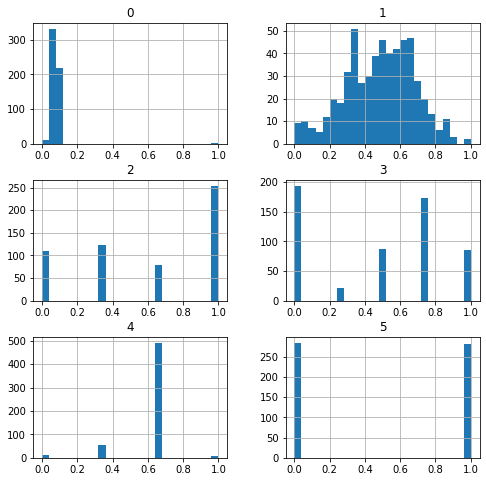

In [3]:
DATA_PATH = "data/mammographic.csv"
data = pd.read_csv(DATA_PATH, header=None)
data = data.drop_duplicates()
data.hist(bins=25, figsize=(8, 8));

One can see that the dataset is balanced (criterion 5 treated as target). However, it can be noticed that the criterion 0 is highly imbalanced and the majority of of examples oscilates around 0.

In [4]:
criteria_nr = 5
data_input = data.iloc[:, :criteria_nr]
data_target = data[criteria_nr]

print(data_input.head())
print(data_target.head())

          0         1         2     3         4
0  0.090909  0.628205  0.666667  1.00  0.666667
1  0.090909  0.512821  1.000000  1.00  0.666667
2  0.072727  0.128205  0.000000  0.00  0.666667
3  0.090909  0.500000  0.000000  1.00  0.666667
4  0.090909  0.743590  0.000000  0.75  0.666667
0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: 5, dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target, test_size=0.2, random_state=1234
)

## Experiments

### ML model - XGBoost

In [9]:
xgb_params = {
    "max_depth": criteria_nr * 2,
    "eta": 0.1,
    "nthread": 2,
    "seed": 0,
    "eval_metric": "rmse",
    "monotone_constraints": "(" + ",".join(["1"] * criteria_nr) + ")",
    "n_estimators": 1,
}

In [10]:
model = xgb.XGBClassifier(**xgb_params)
_ = model.fit(X_train, y_train)

In [11]:
def score_model(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred), 4)
    f1 = round(f1_score(y_true, y_pred), 4)
    auc = round(roc_auc_score(y_true, y_pred), 4)
    return accuracy, f1, auc

In [12]:
y_pred = model.predict(X_train)

accuracy, f1, auc = score_model(y_train, y_pred)
print(f"Train\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")

Train
Accuracy: 0.7982
F1: 0.7859
AUC: 0.7974


In [13]:
y_pred = model.predict(X_test)

accuracy, f1, auc = score_model(y_test, y_pred)
print(f"Test\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")

Test
Accuracy: 0.8319
F1: 0.8224
AUC: 0.8358


#### Interpreting the model

<Axes: >

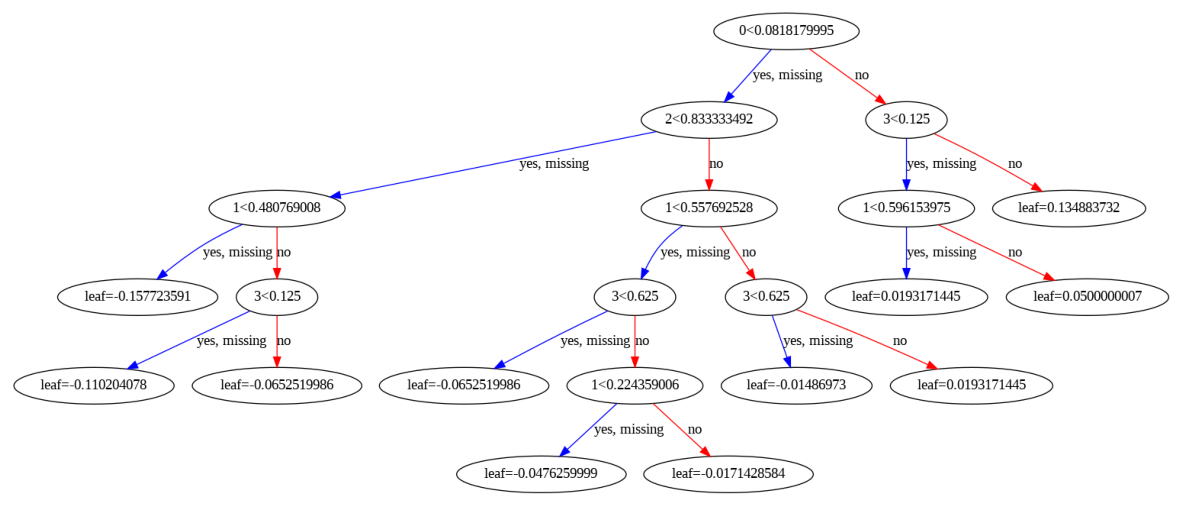

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model, ax=ax, num_trees=0)

In [17]:
pred = model.predict(X_test, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


1.6763806e-08

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


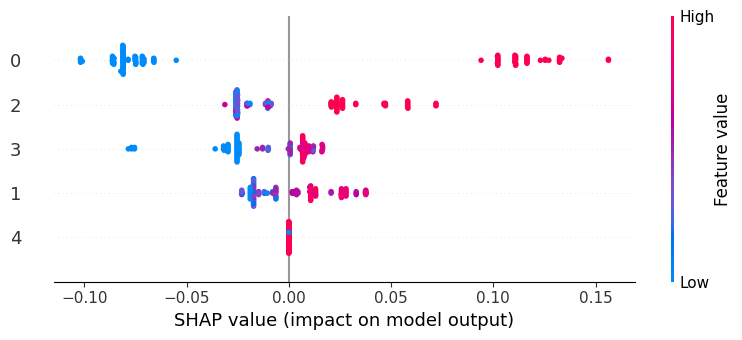

In [18]:
shap.summary_plot(shap_values, X_test)

The plot confirms the previous reasoning regarding features importance.

#### Taking 3 alternatives and veryfing what the minimum change to a single criterion should be done to change classification

In [19]:
samples_3 = X_test.iloc[:3].copy()
samples_3

,0,1,2,3,4
682,0.072727,0.628205,0.0,0.75,0.666667
266,0.072727,0.346154,0.0,0.25,0.666667
231,0.072727,0.628205,1.0,0.00,0.666667


In [20]:
y_pred = model.predict(samples_3)
y_pred

array([0, 0, 0])

For all the alternatives the minimal value to change classifications seems to exist for criterion 0. As it can be seen on the plots, it is most important feature, what explain such change.

In [21]:
# changing the values to verify theoretical predictions
samples_3[0] = 0.0819
samples_3

,0,1,2,3,4
682,0.0819,0.628205,0.0,0.75,0.666667
266,0.0819,0.346154,0.0,0.25,0.666667
231,0.0819,0.628205,1.0,0.00,0.666667


In [22]:
y_pred = model.predict(samples_3)
y_pred

array([1, 1, 1])

The results agree with theoretical predictions.

In [23]:
# explaining predictions for each object
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], samples_3.iloc[0])

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], samples_3.iloc[1])

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], samples_3.iloc[2])

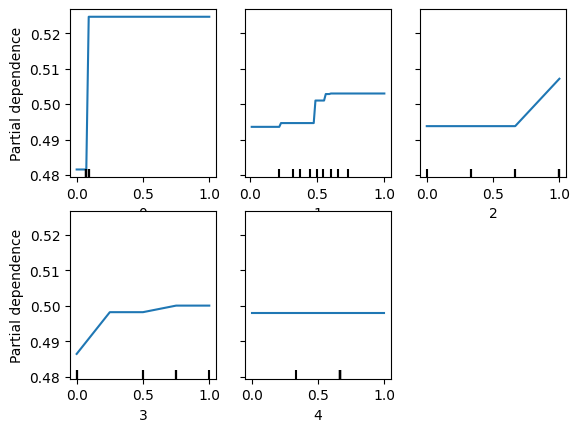

In [27]:
PartialDependenceDisplay.from_estimator(model, X_train, [0, 1, 2, 3, 4])

In [30]:
result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)
result.importances_mean

array([0.25210643, 0.02682927, 0.01108647, 0.01441242, 0.        ])

As can be seen on the plot, criterion 4 has no effect on the decisions. All of other criteria have decisive influence. Criterion 1 is significantly more important than other criteria.

### Neural MCDA

In [ ]:
# copy from martyns?

### NN

In [6]:
def data_loader(X, y):
    dataset = helpers.NumpyDataset(X, y)
    return DataLoader(dataset, batch_size=16)

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, criteria_nr=5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(criteria_nr, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [8]:
def train(model, train_dataloader, lr=0.01, epoch_nr=10):
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.99))
    criterion = nn.BCELoss()
    for epoch in range(epoch_nr):
        with tqdm(train_dataloader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for data in tepoch:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (outputs.round() == labels).float().mean()

                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item(), accuracy=100 * accuracy)
                sleep(0.01)

In [9]:
data_inputs = data_input.values.reshape(-1, 1, criteria_nr)
data_targets = data_target.values.reshape(-1, 1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    data_inputs, data_targets, test_size=0.2, random_state=23
)

train_dataloader = data_loader(X_train, y_train)
test_dataloader = data_loader(X_test, y_test)

In [10]:
model = SimpleNN()
train(model, train_dataloader, lr=0.001)

  0%|          | 0/29 [00:00<?, ?batch/s]

RuntimeError: Found dtype Long but expected Float

In [64]:
model.eval()
y_pred = []
y_labels = []

for data in test_dataloader:
    inputs, labels = data
    outputs = model(inputs)
    y_pred.append(outputs.round().float().detach().numpy().flatten())
    y_labels.append(labels.detach().numpy().flatten())

# y_labels = np.array(y_labels)
# print(y_labels.flatten())
# print(y_pred)
    accuracy, f1, auc = score_model(y_labels, y_pred)
    print(f"Train\nAccuracy: {accuracy}\nF1: {f1}\nAUC: {auc}")

ValueError: ignored

## Summary